# Part 2 - Classification with PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Hyperparameters

In [ ]:
device = 'cuda'
n_epochs = 10
batch_size_train = 128
batch_size_test = 32

# Prepare MNIST image dataset

Using torchvision api to download MNIST data

In [ ]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                                       transform=transform)
validation_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                      transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, 
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test, 
                                           shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Define Model

In [ ]:
# Create simple model with only 1 input, 1 hidden and 1 output layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 784 input node, 50 hidden output
        self.fc1 = nn.Linear(784, 50)
        # 50 input. Input must be same as output of layer before
        # 10 is the output of the model. Number of classes of data
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
# Initialize model and send to GPU
network = Net().to(device)

# Set algorithm for parameter update
optimizer = optim.Adam(network.parameters())

# Train Model

In [ ]:
train_losses, train_counter, val_losses = [], [], []

In [ ]:
# Almost the same format with training loop.
# But, without .backward(), .step()
# Also using different data loader.
def evaluate():
    network.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)
            output = network(data)
            val_loss += F.nll_loss(output, target, size_average=False).item() 
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    val_loss /= len(validation_loader.dataset)
    val_losses.append(val_loss)
    print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset),
        100. * correct / len(validation_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):

    # Print training loss for every 10 batch
    log_interval = 10

    # Set model to training mode
    # Change behavior of some layers like batchnorm, dropout, etc
    network.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        # Send tensor to specified device
        # Default on CPU
        # Sending them to GPU OR CUDA
        data, target = data.to(device), target.to(device)

        # Reset all gradient to zero after each iteration
        # To prevent gradient accumulation
        optimizer.zero_grad()

        # Change shape of input data to fit format of fully connected
        data = data.view(data.shape[0], -1)

        # Forward pass
        output = network(data)

        # Loss Calculation
        loss = F.nll_loss(output, target)

        # Calculate the update value for every parameters
        # Does not update parameter value
        loss.backward()

        # Update all parameters according to the gradient value
        optimizer.step()
        
        # Print training loss
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    # Perform evaluation
    evaluate()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321084
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.010988
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.703274
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.259759
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.023933
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.819765
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.700900
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.706624
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.627316
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.658566
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.477103
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.503648
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.485494
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.415338
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.419915
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.370160
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.417411
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.307647
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.429700
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.308997
Train Epoch: 1 [

# View Evaluation

In [ ]:
# Evaluate on one batch only
examples = enumerate(validation_loader)
batch_idx, (example_data, example_targets) = next(examples)

# To run model without performing grading parameters
with torch.no_grad():

    # Prepare dataset
    pred_data = example_data
    pred_data = pred_data.view(pred_data.shape[0], -1)

    # Set model to evaluation mode
    network.eval()

    # Inference
    predictions = network(pred_data.to(device))

    # Format predictions to get labels
    predicted_labels = predictions.data.max(1, keepdim=True)[1].cpu().detach().numpy()

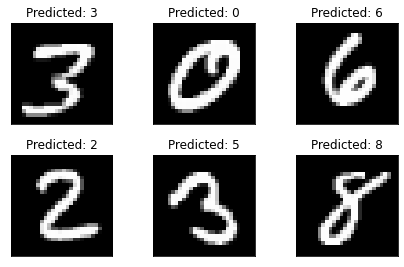

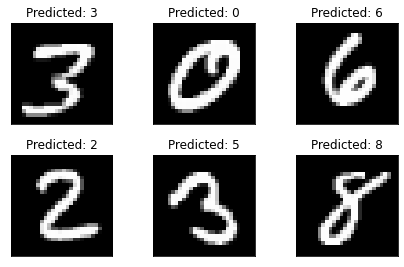

In [ ]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Predicted: {}".format(predicted_labels[i][0]))
    plt.xticks([])
    plt.yticks([])
fig

### View model weights

In [ ]:
for name, param in network.state_dict().items():
    print("Layer: ", name)
    print(param)
    print()

Layer:  fc1.weight
tensor([[-0.0214, -0.0042, -0.0112,  ..., -0.0272, -0.0112, -0.0062],
        [ 0.0281, -0.0257, -0.0217,  ..., -0.0306, -0.0349,  0.0249],
        [ 0.0158, -0.0137,  0.0337,  ...,  0.0285,  0.0056, -0.0002],
        ...,
        [ 0.0273,  0.0263,  0.0192,  ..., -0.0198, -0.0231, -0.0245],
        [ 0.0193,  0.0049,  0.0171,  ..., -0.0008, -0.0332, -0.0233],
        [-0.0289,  0.0003,  0.0291,  ...,  0.0228, -0.0202, -0.0247]],
       device='cuda:0')

Layer:  fc1.bias
tensor([ 0.2046,  0.0738,  0.1783,  0.1528, -0.0376,  0.1006, -0.0069, -0.0665,
        -0.0084, -0.2806,  0.0952,  0.1612,  0.0737,  0.0053,  0.2916, -0.2916,
        -0.1399, -0.1305, -0.1306, -0.2867,  0.1136,  0.0603,  0.0850,  0.0512,
         0.2385,  0.2474, -0.1040, -0.0429,  0.1087, -0.0298,  0.2788,  0.1589,
         0.0309,  0.0472,  0.1078, -0.0955,  0.1218,  0.1388, -0.0129,  0.1634,
         0.1825,  0.2289,  0.0768,  0.0520,  0.0362,  0.2229,  0.1261, -0.0248,
         0.0900,  0.1513]